In [1]:
!pip install -qq speechbrain
!pip install -qq seaborn
!pip install -Uqq huggingface_hub

In [2]:
import speechbrain as sb
from speechbrain.pretrained import SpeakerRecognition, EncoderClassifier
from speechbrain.dataio.dataio import read_audio
from speechbrain.utils.metric_stats import EER
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm
import random
import itertools


In [3]:
# read metadata
metadata = pd.read_csv(f'metadata.csv', dtype={'baby_id':str, 'chronological_index':str})
train_metadata = metadata.loc[metadata['split']=='train'].copy()
train_metadata.head()

,baby_id,period,duration,split,chronological_index,file_name,file_id
45,0369,B,1.16,train,000,audio/train/0369/B/0369_B_000.wav,0369_B_000
46,0369,B,0.83,train,001,audio/train/0369/B/0369_B_001.wav,0369_B_001
47,0369,B,1.32,train,002,audio/train/0369/B/0369_B_002.wav,0369_B_002
48,0369,B,0.89,train,003,audio/train/0369/B/0369_B_003.wav,0369_B_003
49,0369,B,0.92,train,004,audio/train/0369/B/0369_B_004.wav,0369_B_004


In [4]:
encoder = SpeakerRecognition.from_hparams(
    source="Ubenwa/ecapa-voxceleb-ft-cryceleb",
    savedir=f"ecapa-voxceleb-ft-cryceleb",
    run_opts={"device":"cuda"} #comment out if no GPU available
)

In [5]:
# read the segments
train_metadata['cry'] = train_metadata.apply(lambda row: read_audio(row['file_name']).numpy(), axis=1)
# concatenate all segments for each (baby_id, period) group
cry_dict = pd.DataFrame(train_metadata.groupby(['baby_id', 'period'])['cry'].agg(lambda x: np.concatenate(x.values)), columns=['cry']).to_dict(orient='index')
# encode the concatenated cries
for (baby_id, period), d in tqdm(cry_dict.items()):
    d['cry_encoded'] = encoder.encode_batch(torch.tensor(d['cry']), normalize=False)

  0%|          | 0/934 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [14]:
# Split the keys into two separate lists based on 'B' and 'D'
data_B = {k[0]: v for k, v in cry_dict.items() if k[1] == 'B'}
data_D = {k[0]: v for k, v in cry_dict.items() if k[1] == 'D'}

# Find common keys in both 'B' and 'D'
common_keys = set(data_B.keys()).intersection(set(data_D.keys()))

# Create all possible combinations of 'B' and 'D' entries using only common keys
combinations = list(itertools.product(common_keys, repeat=2))

# Prepare data for DataFrame
baby_id_B = [b for b, _ in combinations]
baby_id_D = [d for _, d in combinations]
id = [f'{b}B_{d}D' for b, d in combinations]
label = [1 if b == d else 0 for b, d in combinations]

# Create DataFrame
train_pairs = pd.DataFrame({
    'baby_id_B': baby_id_B,
    'baby_id_D': baby_id_D,
    'id': id,
    'label': label
})

In [18]:
train_pairs

,baby_id_B,baby_id_D,id,label,score
0,0345,0345,0345B_0345D,1,0.017743
1,0345,0619,0345B_0619D,0,0.160471
2,0345,0276,0345B_0276D,0,0.224764
3,0345,0458,0345B_0458D,0,0.013900
4,0345,0352,0345B_0352D,0,0.135724
...,...,...,...,...,...
121099,0096,0234,0096B_0234D,0,0.022411
121100,0096,1076,0096B_1076D,0,0.051228
121101,0096,0727,0096B_0727D,0,0.001295
121102,0096,0403,0096B_0403D,0,-0.094056


In [19]:
print((train_pairs['label'] == 1).sum()) # We have correctly 348 pairs with both B and D as mentioned in the paper

348


In [20]:
train_pairs

,baby_id_B,baby_id_D,id,label,score
0,0345,0345,0345B_0345D,1,0.017743
1,0345,0619,0345B_0619D,0,0.160471
2,0345,0276,0345B_0276D,0,0.224764
3,0345,0458,0345B_0458D,0,0.013900
4,0345,0352,0345B_0352D,0,0.135724
...,...,...,...,...,...
121099,0096,0234,0096B_0234D,0,0.022411
121100,0096,1076,0096B_1076D,0,0.051228
121101,0096,0727,0096B_0727D,0,0.001295
121102,0096,0403,0096B_0403D,0,-0.094056


In [21]:
def compute_cosine_similarity_score(row, cry_dict):
    cos = torch.nn.CosineSimilarity(dim=-1)
    similarity_score = cos(
      cry_dict[(row['baby_id_B'], 'B')]['cry_encoded'], 
      cry_dict[(row['baby_id_D'], 'D')]['cry_encoded']
    )
    return similarity_score.item()
train_pairs['score'] = train_pairs.apply(lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict), axis=1)
display(train_pairs.head())

,baby_id_B,baby_id_D,id,label,score
0,0345,0345,0345B_0345D,1,0.017743
1,0345,0619,0345B_0619D,0,0.160471
2,0345,0276,0345B_0276D,0,0.224764
3,0345,0458,0345B_0458D,0,0.013900
4,0345,0352,0345B_0352D,0,0.135724


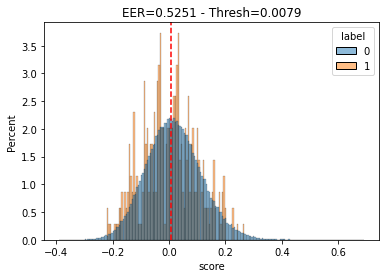

In [22]:
def compute_eer_and_plot_verification_scores(pairs_df):
    ''' pairs_df must have 'score' and 'label' columns'''
    positive_scores = pairs_df.loc[pairs_df['label']==1]['score'].values
    negative_scores = pairs_df.loc[pairs_df['label']==0]['score'].values
    eer, threshold = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
    ax = sns.histplot(pairs_df, x='score', hue='label', stat='percent', common_norm=False)
    ax.set_title(f'EER={round(eer, 4)} - Thresh={round(threshold, 4)}')
    plt.axvline(x=[threshold], color='red', ls='--');
    return eer, threshold

eer, threshold = compute_eer_and_plot_verification_scores(pairs_df=train_pairs)